In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import cv2 as cv
sns.set_theme()
plt.rcParams['figure.figsize'] = [16,10]

In [3]:
CYCLIC_COLUMNS = ["PSVTime", "PSV", "PDVTime", "PDV", "EDVTime", "EDV", "ISVTime", "ISV", "MBF1", "MBF2", "SysTime", "DiasTime", "OSI", "WindowTime"]
TIME_SERIES_COLUMNS = ["Time","BloodFlow","Filtered Blood Flow", "Shear", "Filtered Shear", "Velocity", "Diameter"]
ANALYSIS_SETTINGS_COLUMNS = ["Peak Height Threshold", "Cycle Duration", "Peak Count", "EpochEndTime", "Velocity Calibration", "Time Calibration", "Distance Calibration", "Zero Velocity Row Position"]

In [4]:
def subj_file(subj_str: str, trial_type: str, data_type: str):
    folder = f"bloodflow_data/{subj_str}"
    filename = None
    files = None
    
    if trial_type in ['baseline', 'base', 'basline']:
        files = [file_name for file_name in os.listdir(folder) if 'baseline' in file_name or 'basline' in file_name or 'base' in file_name]

    elif trial_type in ['post-oc', 'post-occ', 'post-occlusion', 'post']:
        files = [file_name for file_name in os.listdir(folder) if 'post' in file_name]

    else:
        raise ValueError(f"{trial_type} is not an acceptable parameter for trial_type")
    
    if data_type in ['diameter', 'diam']:
        files = [file_name for file_name in files if 'diam' in file_name]
        filename = files[0][:-4]
    elif data_type in ['time', 'time_series', 'time series', 'cyclic'] :
        files = [file_name for file_name in files if 'flow' in file_name or 'doppler' in file_name]
        filename = files[0][:str.index(files[0], '_')]
        
    else:
        raise ValueError(f"{data_type} is not an acceptable parameter for data_type")
    
    return f"{folder}/{filename}", data_type

In [5]:
def load(subj_file):
    data = pd.DataFrame()
    if subj_file[1] in ['diameter', 'diam']:
        data['diameter'] = np.load(f"{subj_file[0]}.npy")['diameters']
        
    elif subj_file[1] == 'cyclic':
        data = pd.read_csv(f"{subj_file[0]}_cyclic.csv", header = None)
        data.columns = CYCLIC_COLUMNS
        
    elif subj_file[1] in ['time', 'time_series', 'time series']:
        data = pd.read_csv(f"{subj_file[0]}_time_series.csv", header = None)
        data.columns = TIME_SERIES_COLUMNS
    
    return data

In [7]:
def shear_subject(subj_name: str, baseline: bool, plot = False):
    time_series = None

    if baseline:
        time_series = load(subj_file(subj_name, 'baseline', 'time'))
    else:
        time_series = load(subj_file(subj_name, 'post', 'time'))


    threshold = np.nanmean(time_series['Filtered Shear'])

    peak_indices = sp.signal.find_peaks(time_series['Filtered Shear'], prominence = 100, width = 5, height = threshold)[0]
    peak_values = time_series['Filtered Shear'].iloc[peak_indices]
    
    max_peak = peak_values.max()
    valid_peaks = peak_values > max_peak * 0.75
    peaks = peak_indices[valid_peaks]
    
    peak_choices = None
    if not baseline:
        moving_peaks = pd.Series(time_series['Filtered Shear'].iloc[peaks]).rolling(window = 5, center = True).mean()
        peak_choices = peaks.copy()
        
        peak_max_index = moving_peaks.argmax()
        
        lower = max(0, peak_max_index-2)
        upper = min(len(peaks), peak_max_index+3)
        peaks = peaks[lower:upper]


    if plot:
        sns.lineplot(time_series['Filtered Shear'])
        
        if not baseline:
            sns.scatterplot(x=peak_choices, y = time_series['Filtered Shear'].iloc[peak_choices], color = 'orange')
        
        sns.scatterplot(x=peaks, y=time_series['Filtered Shear'].iloc[peaks], color="fuchsia")
        
        tag = "Baseline" if baseline else "Post-Occlusion"
        plt.title(f"{subj_name} {tag} Filtered Shear Rate")
        plt.ylabel("Shear Rate")
        plt.xlabel("Frame #")
        plt.show()

    return time_series['Filtered Shear'].iloc[peaks].mean()

In [8]:
subj_numbers = list(range(5,25))
exclude = [19]

In [9]:
baseline_shear = np.empty(len(subj_numbers))
post_shear     = np.empty(len(subj_numbers))

for i, subj_num in enumerate(subj_numbers):
    
    subj_name = f"ASCI{subj_num:03}"
    
    if subj_num in exclude:
        baseline_shear[i] = 0
        post_shear[i] = 0
        continue
    
    baseline_shear[i] = shear_subject(subj_name, baseline=True, plot = False)
    post_shear[i]     = shear_subject(subj_name, baseline=False, plot = False)
    
baseline_sci = baseline_shear.copy()
post_sci = post_shear.copy()

C:\Users\M315697\AppData\Local\Temp\ipykernel_21460\2572025487.py:24: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  peak_max_index = moving_peaks.argmax()


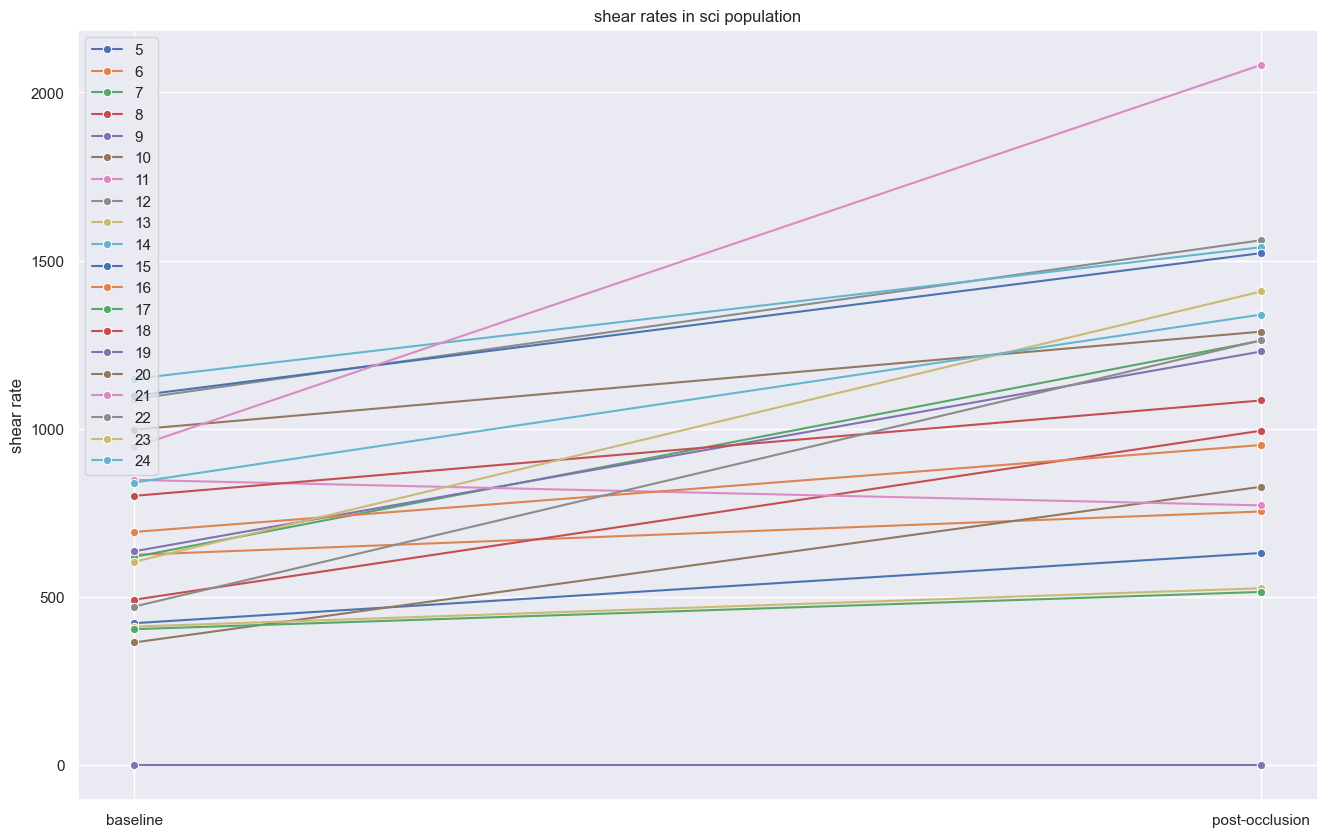

In [10]:
shears = np.column_stack([baseline_shear, post_shear])

for shear_pair, subj_num in zip(shears, subj_numbers):
    sns.lineplot(x = [0,1], y = shear_pair, marker = 'o', label = subj_num)

plt.title("shear rates in sci population")
plt.ylabel("shear rate")
plt.xticks([0,1],["baseline", "post-occlusion"])
plt.show()

In [11]:
subj_numbers = list(range(1,15))

In [12]:
baseline_shear = np.empty(len(subj_numbers))
post_shear     = np.empty(len(subj_numbers))

for i, subj_num in enumerate(subj_numbers):
    
    subj_name = f"ASCI1{subj_num:02}"
    
    baseline_shear[i] = shear_subject(subj_name, baseline=True, plot = False)
    post_shear[i]     = shear_subject(subj_name, baseline=False, plot = False)
    
baseline_control = baseline_shear.copy()
post_control = post_shear.copy()

C:\Users\M315697\AppData\Local\Temp\ipykernel_21460\2572025487.py:24: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  peak_max_index = moving_peaks.argmax()


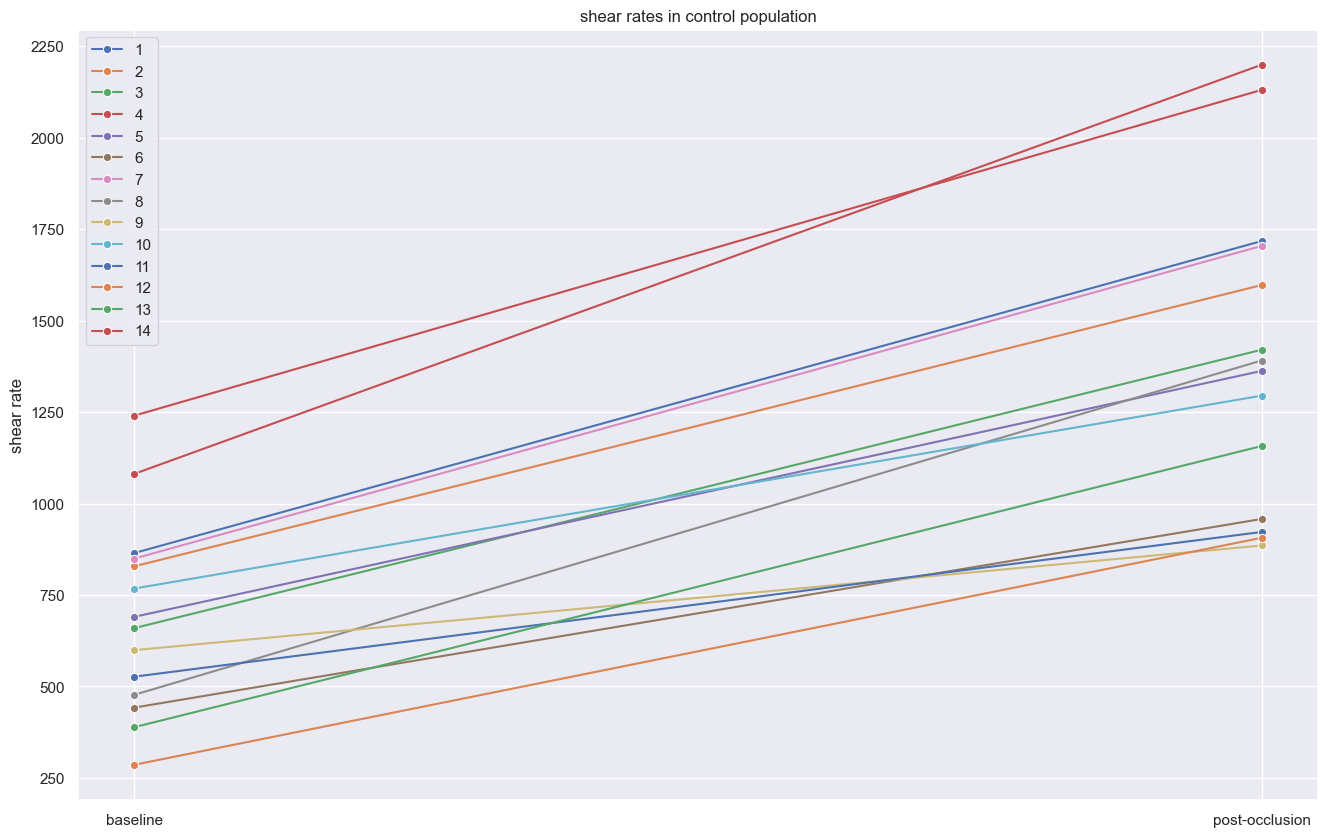

In [13]:
shears = np.column_stack([baseline_shear, post_shear])

for shear_pair, subj_num in zip(shears, subj_numbers):
    sns.lineplot(x = [0,1], y = shear_pair, marker = 'o', label = subj_num)

plt.title("shear rates in control population")
plt.ylabel("shear rate")
plt.xticks([0,1],["baseline", "post-occlusion"])
plt.show()

In [14]:
subj_shears = pd.DataFrame()

sci_nums = list(range(5,25))
control_nums = list(range(1,15))

name = lambda num, sci: f"ASCI{num:03}" if sci else f"ASCI1{num:02}"

sci_names = [name(num, True) for num in sci_nums]
control_names = [name(num, False) for num in control_nums]
names = sci_names + control_names
subj_shears['subject'] = names

subj_shears['baseline shear'] = np.concatenate([baseline_sci, baseline_control])
subj_shears['post-occlusion shear'] = np.concatenate([post_sci, post_control])
subj_shears['shear flat increase'] = subj_shears['post-occlusion shear'] - subj_shears['baseline shear']
subj_shears['shear increase'] = subj_shears['shear flat increase'] / subj_shears['baseline shear']
subj_shears['class'] = ['sci'] * len(sci_nums) + ['control']*len(control_nums)

In [15]:
subj_shears.to_csv("shear_data.csv", index = False)

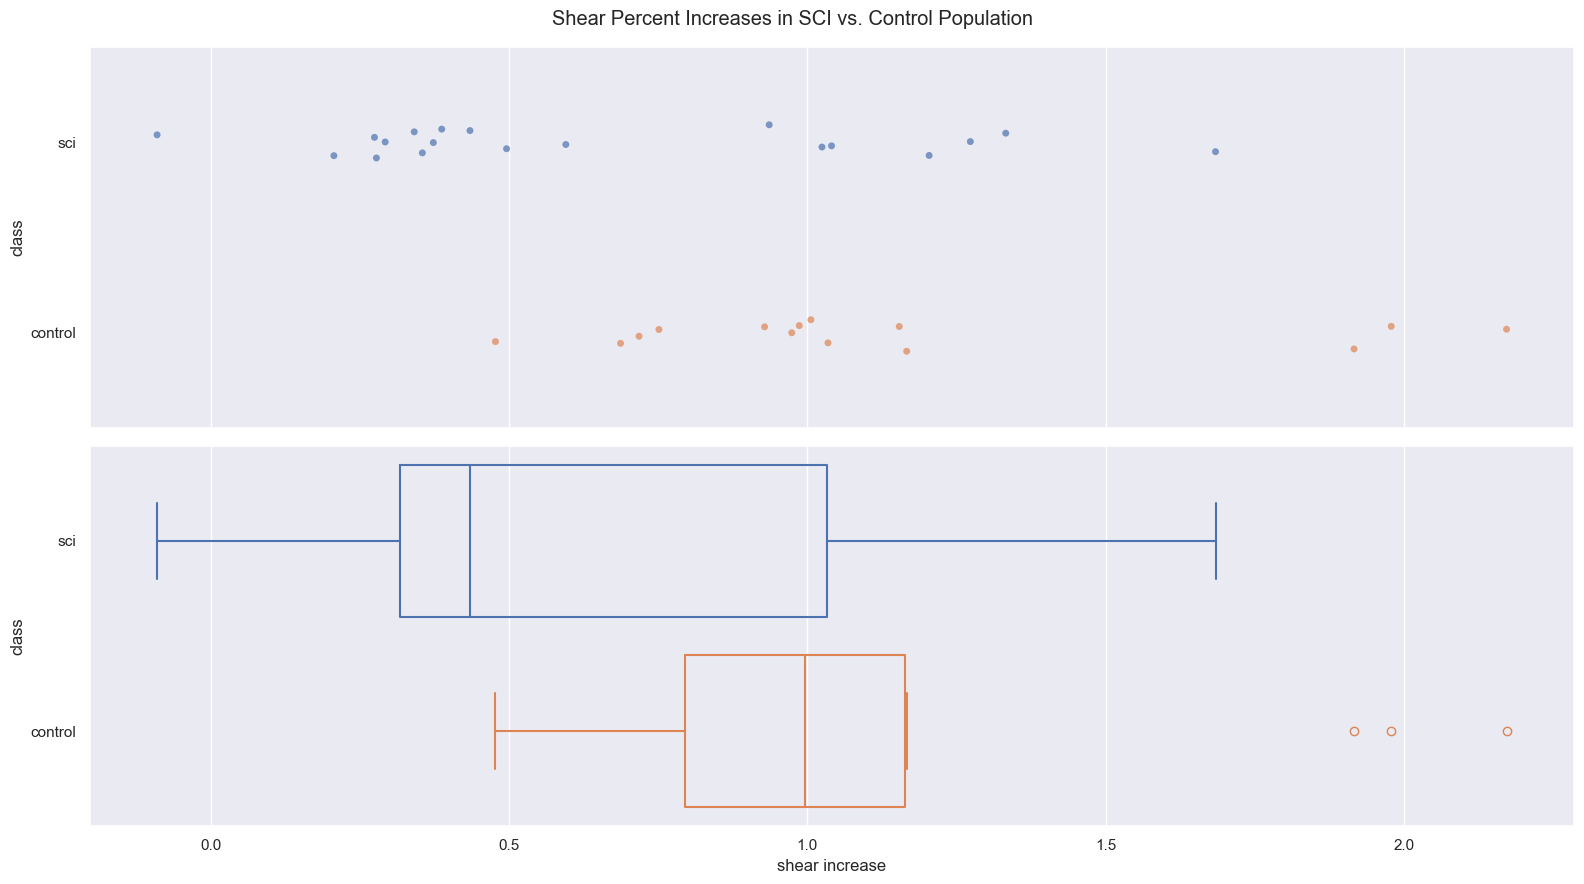

In [16]:
subj_shears = subj_shears[subj_shears['subject'] != "ASCI019"]

fig, ax = plt.subplots(2,1, sharey=True, sharex = True, figsize = (16,9))
sns.stripplot(data = subj_shears, hue = "class", x = "shear increase", y = "class", ax = ax[0], alpha = 0.7)
sns.boxplot(data = subj_shears, hue = "class", x = "shear increase", y = "class", ax = ax[1], fill = None)
plt.suptitle("Shear Percent Increases in SCI vs. Control Population")
plt.tight_layout()
plt.show()

C:\Users\M315697\AppData\Local\Temp\ipykernel_21460\3441965963.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data = subj_shears, hue = "class", x = "shear increase", y = "class", alpha = 0.7, color = 'black')


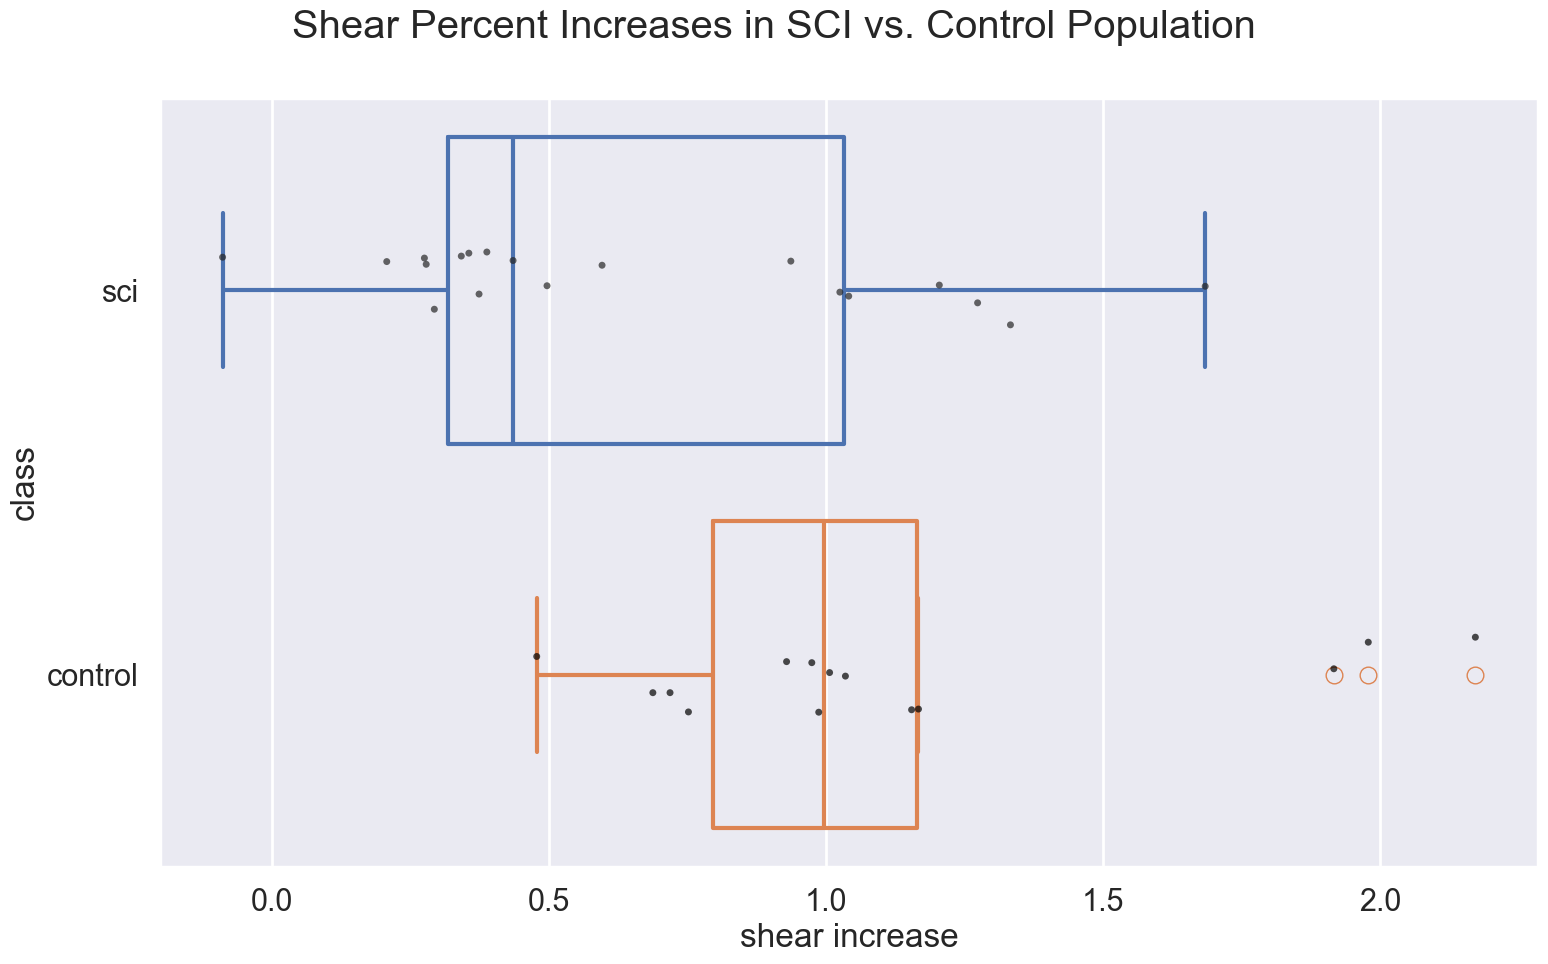

In [17]:
subj_shears = subj_shears[subj_shears['subject'] != "ASCI019"]

sns.set_context("poster")
sns.stripplot(data = subj_shears, hue = "class", x = "shear increase", y = "class", alpha = 0.7, color = 'black')
sns.boxplot(data = subj_shears, hue = "class", x = "shear increase", y = "class", fill = None)
plt.suptitle("Shear Percent Increases in SCI vs. Control Population")
plt.tight_layout()
plt.show()

In [18]:
sci = subj_shears[subj_shears['class'] == 'sci']['shear increase']
control = subj_shears[subj_shears['class'] == 'control']['shear increase']
sp.stats.ttest_ind(sci, control)

TtestResult(statistic=-2.77373616626032, pvalue=0.009299332524793674, df=31.0)

In [19]:
sp.stats.mannwhitneyu(sci, control)

MannwhitneyuResult(statistic=68.0, pvalue=0.018800116181244397)